In [1]:
# # Imports and settings
import pandas as pd
import duckdb
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import xgboost as xgb
import random
import os
import shap
from joblib import dump
from datetime import datetime
from pathlib import Path
from sklearn.metrics import mean_squared_error
from functools import reduce
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.metrics import log_loss
from tqdm import tqdm

pd.set_option('display.float_format', '{:.6f}'.format)
random_seed = 909
random.seed(random_seed)
np.random.seed(random_seed)

# Function to calculate profit based on bet and result
def calculate_profit(row, home_bet_col, away_bet_col):
    if row[home_bet_col] == 1:
        return (row['pp_ltp_home'] - 1.0) * (0.95) if row['winner_home'] == 1 else -1.0
    if row[away_bet_col] == 1:
        return (row['pp_ltp_away'] - 1.0) * (0.95) if row['winner_home'] == 0 else -1.0
    return 0.0

In [2]:
sim_file = pd.read_csv(r"E:\tennis-model\model\outputs\20241015_172829\simulation_file.csv")

In [4]:
price_file = pd.read_csv('../../data/price_file.csv')

In [7]:
sim_file_melt = pd.melt(sim_file, id_vars=[x for x in sim_file.columns if 'selection_id' not in x], value_name='selection_id', var_name='position')

In [13]:
sim_file_melt['selection_id'] = sim_file_melt['selection_id'].astype(int)
sim_file_melt['market_id'] = sim_file_melt['market_id'].astype(str).str.pad(9, fillchar='0', side='right')
price_file['market_id'] = price_file['market_id'].astype(str).str.pad(9, fillchar='0', side='right')

In [11]:
for col in [x for x in sim_file_melt.columns if 'prediction' in x]:
    sim_file_melt.loc[sim_file_melt['position'] == 'selection_id_away', col] = 1 - sim_file_melt[col]

,market_id,tournament_category,tournament_points,prediction_xgb_normal_0,prediction_xgb_normal_1,prediction_xgb_normal_2,prediction_xgb_normal_3,prediction_xgb_normal_4,prediction_xgb_normal_5,prediction_xgb_normal_6,prediction_xgb_normal_7,prediction_xgb_normal_8,prediction_xgb_normal_9,prediction_xgb_normal_avg,position,selection_id
0,1.217962566,Challenger,75,0.118993,0.130184,0.117536,0.114704,0.114868,0.114325,0.120211,0.154034,0.157777,0.111199,0.125383,selection_id_home,41631876
1,1.217987232,ITF Women,0,0.851114,0.835654,0.827917,0.827133,0.783770,0.860465,0.848310,0.821824,0.850214,0.847519,0.835392,selection_id_home,11366608
2,1.217936983,Challenger,75,0.812925,0.815106,0.813955,0.809802,0.809701,0.825003,0.794101,0.798719,0.814990,0.804561,0.809886,selection_id_home,16149495
3,1.217977301,Challenger,125,0.661922,0.735996,0.656687,0.682711,0.685481,0.632174,0.685176,0.669047,0.696472,0.672169,0.677783,selection_id_home,14534269
4,1.217980822,ITF Women,0,0.382913,0.411645,0.330233,0.393644,0.359501,0.381651,0.356049,0.340256,0.375281,0.330190,0.366136,selection_id_home,19248021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1.232472766,Challenger,75,0.555827,0.600190,0.578272,0.603968,0.583102,0.571430,0.574550,0.594448,0.651018,0.561514,0.587432,selection_id_away,12819814
49996,1.232452817,WTA,2000,0.840224,0.845845,0.825794,0.852931,0.849944,0.850432,0.861247,0.832482,0.835791,0.866743,0.846143,selection_id_away,2309522
49997,1.232436166,ATP,2000,0.445659,0.473496,0.488893,0.452288,0.487348,0.459765,0.482475,0.497891,0.486120,0.495764,0.476970,selection_id_away,19924841
49998,1.232445966,ATP,2000,0.820030,0.772914,0.780800,0.807269,0.783889,0.816428,0.792909,0.767589,0.801187,0.782433,0.792545,selection_id_away,8859306


In [14]:
mm_base_table = sim_file_melt.merge(price_file, on=['market_id','selection_id'])

In [55]:
con = duckdb.connect("E:/duckdb/tennis.duckdb",read_only=True)
tennis_markets = con.execute("""
SELECT market_id, selection_id, result FROM  market_summaries m
""").df()
con.close()

In [56]:
mm_base_table = mm_base_table.merge(tennis_markets, on=['market_id','selection_id'])

In [41]:
mm_base_table['avg_pred_ev'] = (mm_base_table['prediction_xgb_normal_avg'] * (mm_base_table['atb'] - 1) * 0.95) - (1 - mm_base_table['prediction_xgb_normal_avg'])

mm_base_table['bet'] = 0
mm_base_table.loc[
    (mm_base_table['avg_pred_ev'] > 0)
    , 'bet'
] = 1

In [42]:
mm_base_table['profit'] = 0.0

mm_base_table['stake'] = 0.0
mm_base_table.loc[mm_base_table['bet'] == 1, 'stake'] = 10.0
mm_base_table.loc[mm_base_table['stake'] > mm_base_table['atb_size'], 'stake'] = mm_base_table['atb_size']

mm_base_table.loc[(mm_base_table['result'] == "LOSER") & (mm_base_table['bet'] == 1),'profit'] = -mm_base_table['stake']
mm_base_table.loc[(mm_base_table['result'] == "WINNER") & (mm_base_table['bet'] == 1),'profit'] = mm_base_table['stake'] * (mm_base_table['atb'] - 1) * 0.95

print(mm_base_table['profit'].sum())
print(mm_base_table['stake'].sum())
print(mm_base_table['profit'].sum() / mm_base_table['stake'].sum())

-1032.9898800000003
17682.48
-0.058418834914559514


In [45]:
pred_cols = [x for x in sim_file_melt.columns if 'prediction' in x and 'avg' not in x]
mm_base_table['pred_var'] = np.var(mm_base_table[pred_cols],axis=1)
mm_base_table['pred_min'] = np.min(mm_base_table[pred_cols],axis=1)
mm_base_table['pred_max'] = np.max(mm_base_table[pred_cols],axis=1)

In [47]:
mm_base_table['min_max'] = mm_base_table['pred_max'] - mm_base_table['pred_min']
mm_base_table['min_mean'] = mm_base_table['pred_max'] - mm_base_table['prediction_xgb_normal_avg']
mm_base_table['max_mean'] = mm_base_table['prediction_xgb_normal_avg'] - mm_base_table['pred_min']

In [48]:
mm_base_table

,market_id,tournament_category,tournament_points,prediction_xgb_normal_0,prediction_xgb_normal_1,prediction_xgb_normal_2,prediction_xgb_normal_3,prediction_xgb_normal_4,prediction_xgb_normal_5,prediction_xgb_normal_6,...,bet,avg_pred_ev,profit,stake,pred_var,pred_min,pred_max,min_max,min_mean,max_mean
0,1.217962566,Challenger,75,0.118993,0.130184,0.117536,0.114704,0.114868,0.114325,0.120211,...,0,-0.362427,0.000000,0.000000,0.000257,0.111199,0.157777,0.046578,0.032394,0.014184
1,1.217987232,ITF Women,0,0.851114,0.835654,0.827917,0.827133,0.783770,0.860465,0.848310,...,0,-0.132863,0.000000,0.000000,0.000438,0.783770,0.860465,0.076695,0.025073,0.051622
2,1.217936983,Challenger,75,0.812925,0.815106,0.813955,0.809802,0.809701,0.825003,0.794101,...,0,-0.067011,0.000000,0.000000,0.000071,0.794101,0.825003,0.030902,0.015117,0.015785
3,1.217977301,Challenger,125,0.661922,0.735996,0.656687,0.682711,0.685481,0.632174,0.685176,...,0,-0.109732,0.000000,0.000000,0.000676,0.632174,0.735996,0.103822,0.058212,0.045609
4,1.217980822,ITF Women,0,0.382913,0.411645,0.330233,0.393644,0.359501,0.381651,0.356049,...,0,-0.146903,0.000000,0.000000,0.000683,0.330190,0.411645,0.081455,0.045509,0.035946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48315,1.232472766,Challenger,75,0.555827,0.600190,0.578272,0.603968,0.583102,0.571430,0.574550,...,0,-0.111215,0.000000,0.000000,0.000672,0.555827,0.651018,0.095190,0.063586,0.031605
48316,1.232452817,WTA,2000,0.840224,0.845845,0.825794,0.852931,0.849944,0.850432,0.861247,...,0,-0.041320,0.000000,0.000000,0.000147,0.825794,0.866743,0.040949,0.020600,0.020349
48317,1.232436166,ATP,2000,0.445659,0.473496,0.488893,0.452288,0.487348,0.459765,0.482475,...,0,-0.119752,0.000000,0.000000,0.000305,0.445659,0.497891,0.052232,0.020921,0.031311
48318,1.232445966,ATP,2000,0.820030,0.772914,0.780800,0.807269,0.783889,0.816428,0.792909,...,0,-0.109576,0.000000,0.000000,0.000294,0.767589,0.820030,0.052441,0.027485,0.024956


In [52]:
id_cols = ['market_id',
 'selection_id_home',
 'selection_id_away','matchup_indices',
 'tournament_name',
 'datetime','match_players']
cat_cols = ['tournament_points', 'tournament_category']
feature_cols = ['pred_var','pred_min','pred_max','min_max','min_mean','max_mean','prediction_xgb_normal_avg'] + pred_cols + ['atb_size','seconds_to_start','last_traded_price','total_matched']
target = ['profit']


In [53]:
df_train = mm_base_table.sort_values('market_id')
df_train[cat_cols] = df_train[cat_cols].astype('category')

# CatBoost parameters (actually XGBoost params in this context)
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'device': 'cuda',
    'tree_method': 'hist',
    'eta': 0.005,
    'max_depth': 4
    # 'colsample_bytree': 0.8
}

# Split data
train_mask = df_train[:35000]
val_mask = df_train[35000:]

X_fold_train, y_fold_train = train_mask[cat_cols + feature_cols], train_mask[target]
X_val, y_val = val_mask[cat_cols + feature_cols], val_mask[target]

df_val = val_mask.copy()
dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train, feature_names=cat_cols + feature_cols, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=cat_cols + feature_cols, enable_categorical=True)

# Add early stopping with validation set
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=500, evals=[(dtrain, 'train'), (dval, 'validation')], verbose_eval=True,early_stopping_rounds=100)

# Make predictions on the validation set
df_val['prediction'] = xgb_model.predict(dval)

[0]	train-rmse:1.89352	validation-rmse:2.40525
[1]	train-rmse:1.89339	validation-rmse:2.40525
[2]	train-rmse:1.89327	validation-rmse:2.40524
[3]	train-rmse:1.89315	validation-rmse:2.40524
[4]	train-rmse:1.89302	validation-rmse:2.40523
[5]	train-rmse:1.89290	validation-rmse:2.40523
[6]	train-rmse:1.89278	validation-rmse:2.40522
[7]	train-rmse:1.89266	validation-rmse:2.40522
[8]	train-rmse:1.89254	validation-rmse:2.40519
[9]	train-rmse:1.89242	validation-rmse:2.40519
[10]	train-rmse:1.89231	validation-rmse:2.40516
[11]	train-rmse:1.89219	validation-rmse:2.40515
[12]	train-rmse:1.89208	validation-rmse:2.40512
[13]	train-rmse:1.89196	validation-rmse:2.40512
[14]	train-rmse:1.89185	validation-rmse:2.40514
[15]	train-rmse:1.89174	validation-rmse:2.40511
[16]	train-rmse:1.89163	validation-rmse:2.40512
[17]	train-rmse:1.89152	validation-rmse:2.40509
[18]	train-rmse:1.89141	validation-rmse:2.40509
[19]	train-rmse:1.89130	validation-rmse:2.40511
[20]	train-rmse:1.89119	validation-rmse:2.40510
[2

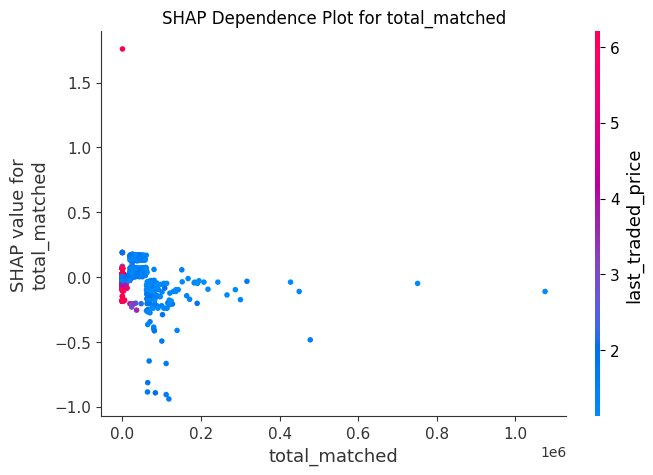

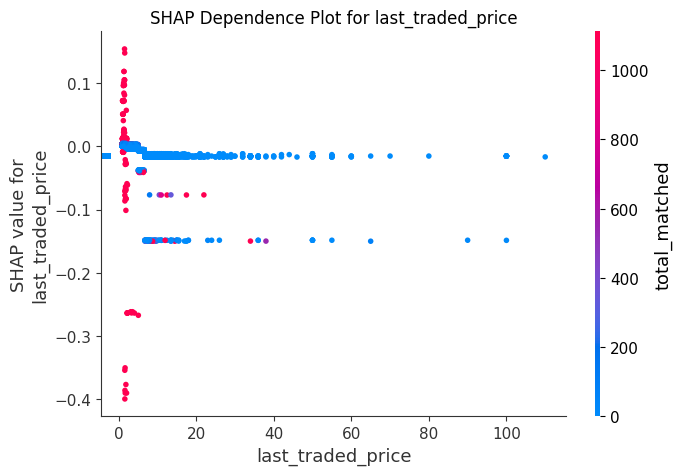

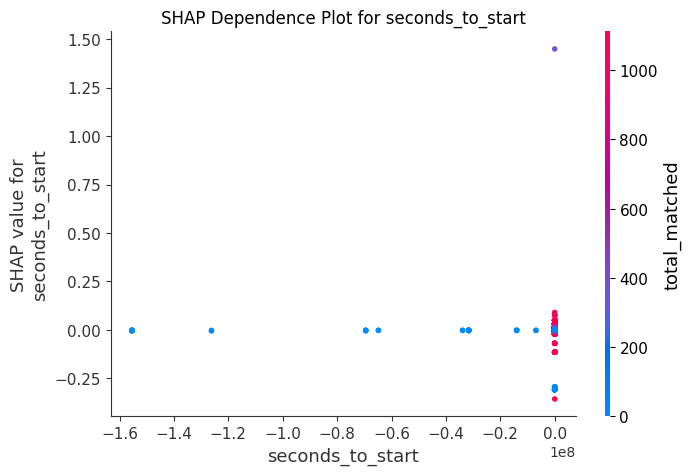

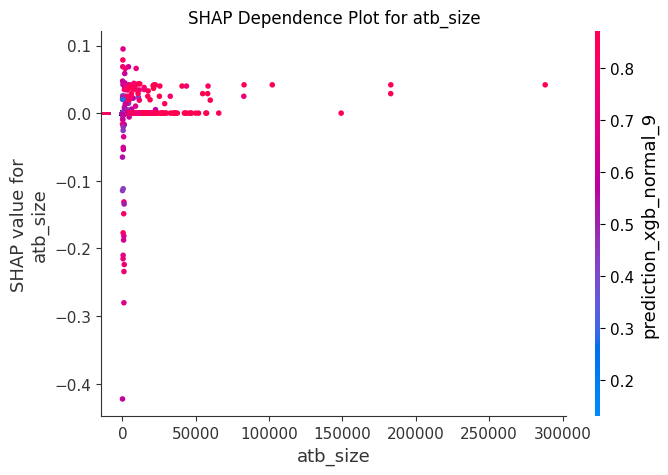

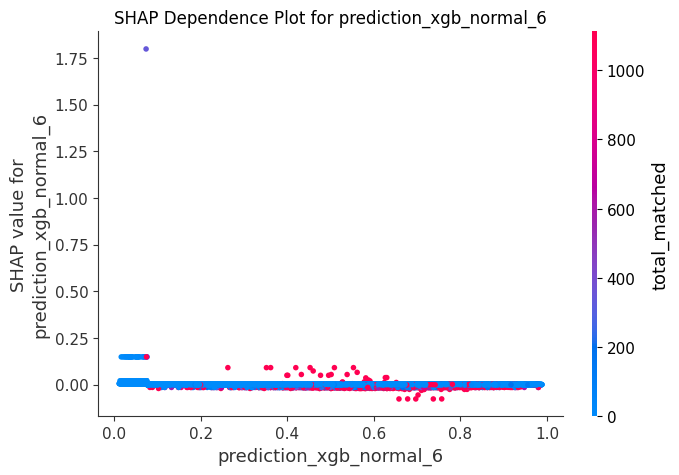

E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


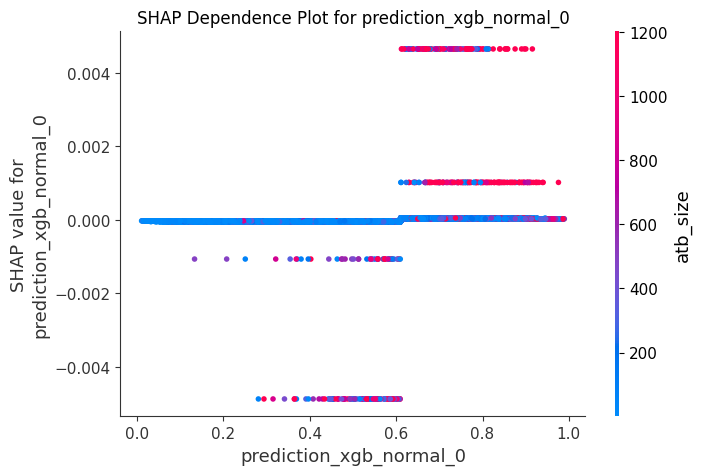

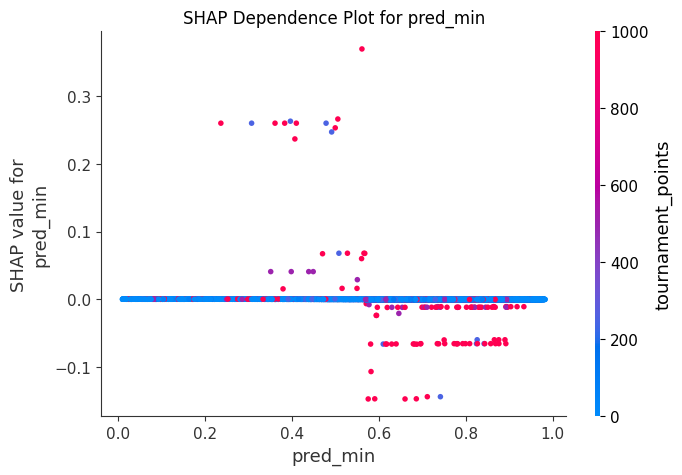

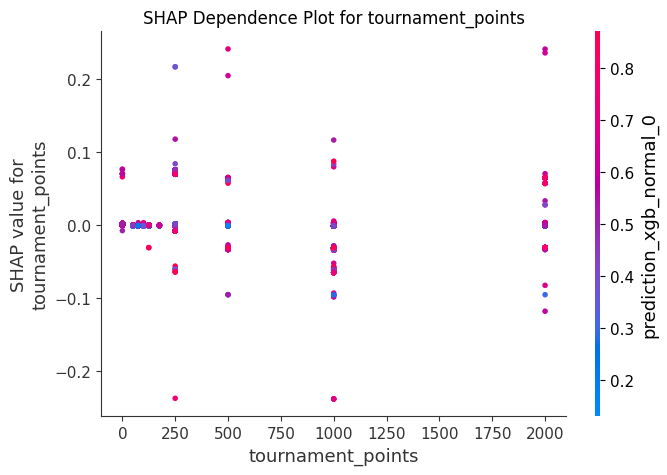

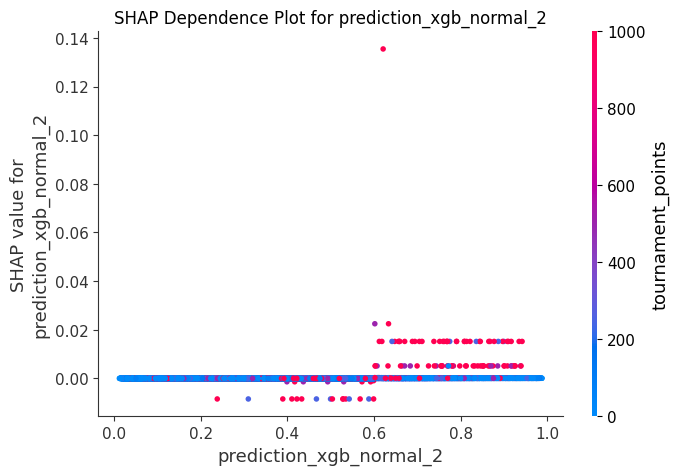

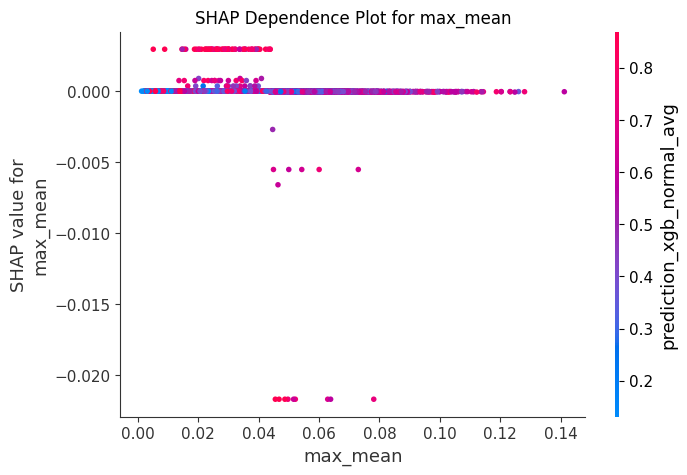

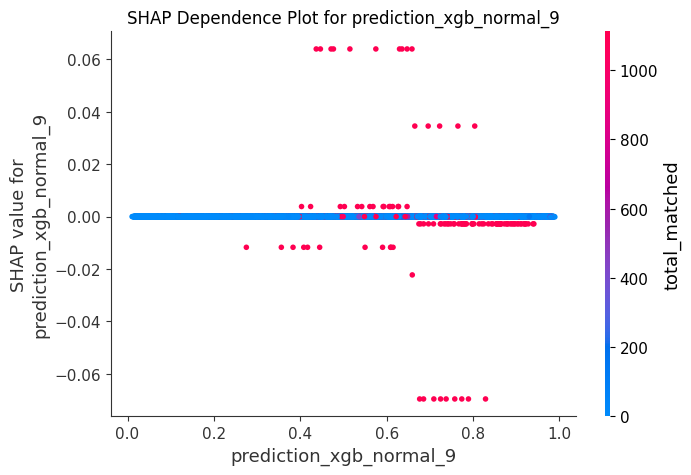

E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


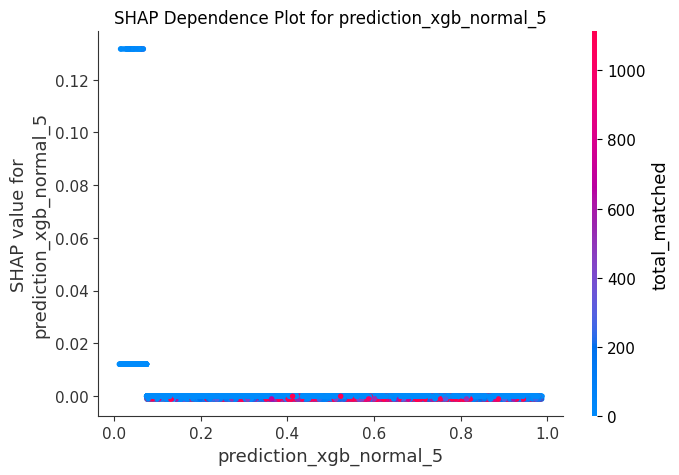

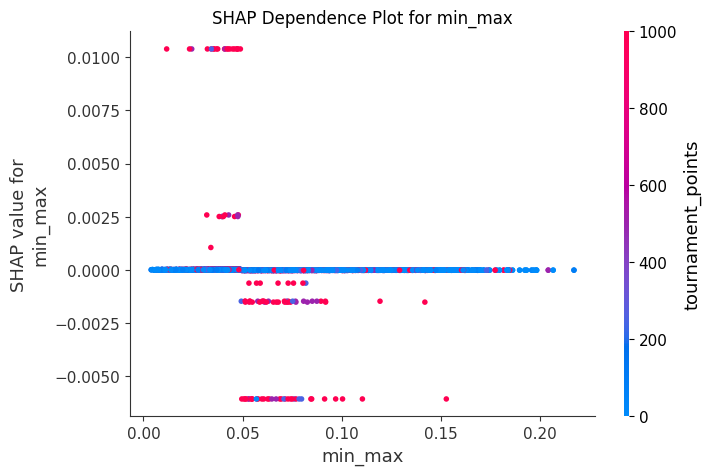

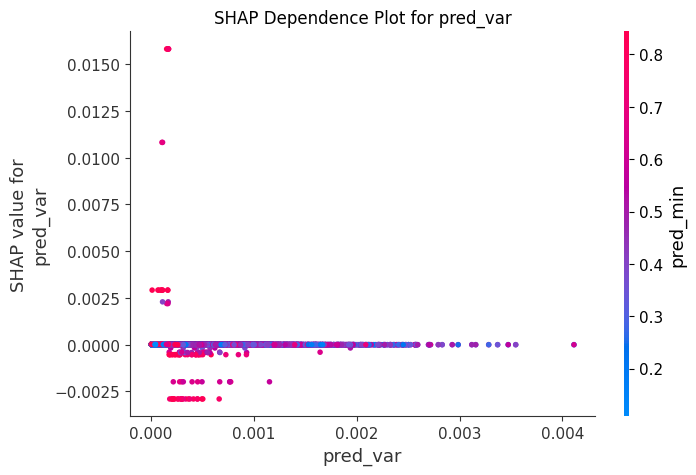

E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


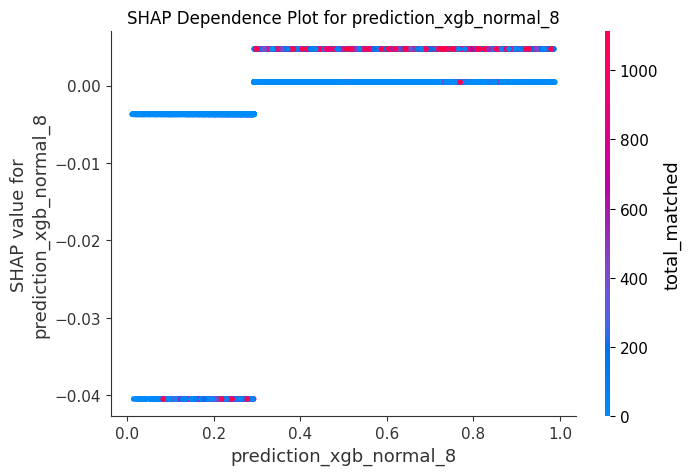

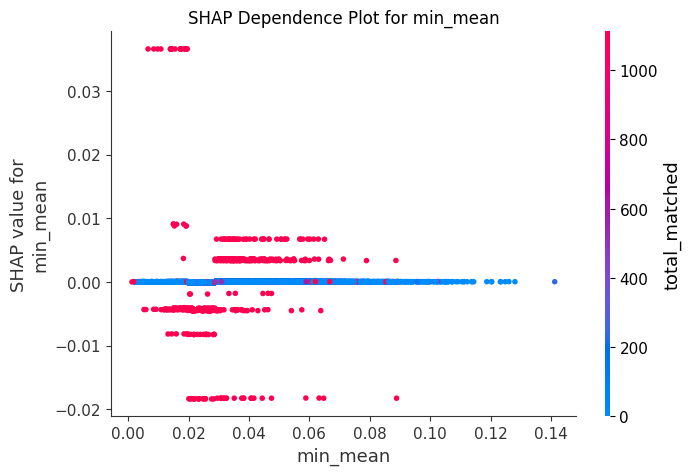

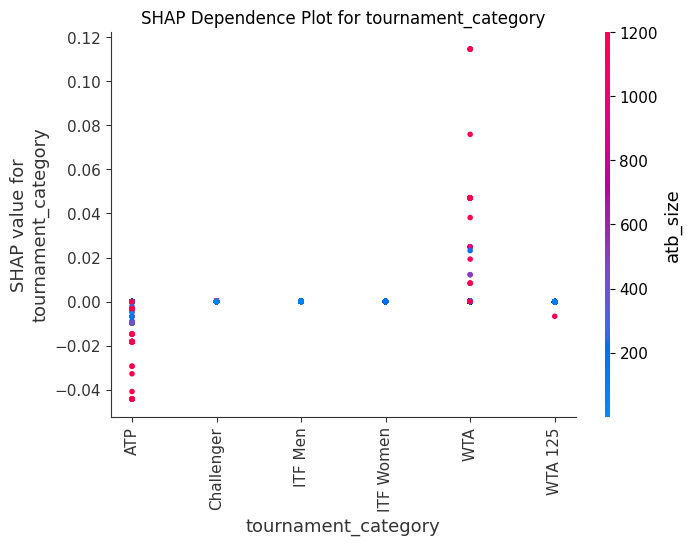

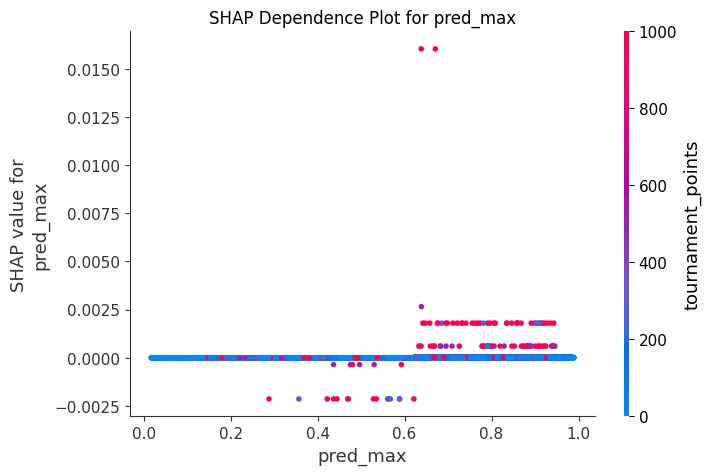

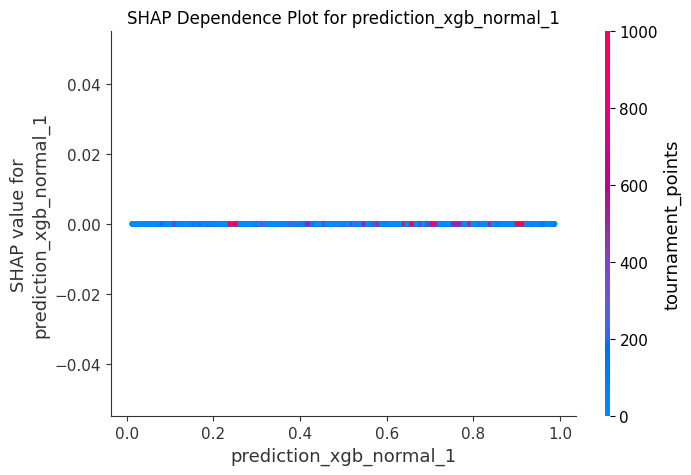

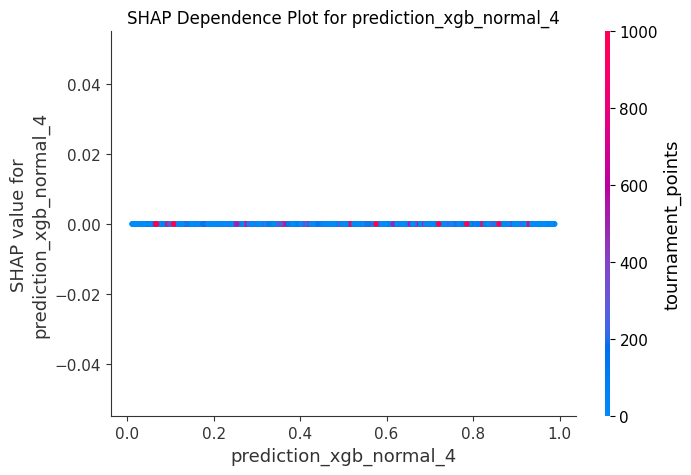

In [54]:
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Calculate SHAP values using the TreeExplainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(dtrain)  # Using SHAP's new interface directly on the data

# Get feature importance from the model
importance_dict = xgb_model.get_score(importance_type='weight')  # This returns a dictionary
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['feature', 'importance'])

# Sort by importance and select top 20 features
top_20_features = importance_df.sort_values(by='importance', ascending=False).head(20)['feature'].tolist()

# Create SHAP dependence plots for the top 20 features with slope estimation
for feature in top_20_features:
    # Plot SHAP dependence
    shap.dependence_plot(feature, shap_values.values, X_fold_train, show=False)

    # Extract feature values and SHAP values for linear regression
    feature_values = X_fold_train[feature].values.reshape(-1, 1)
    shap_vals = shap_values[:, X_fold_train.columns.get_loc(feature)].values  # Access SHAP values correctly
    # 
    # # Fit a linear regression model to estimate slope
    # reg = LinearRegression().fit(feature_values, shap_vals)
    # slope = reg.coef_[0]

    # Overlay the slope on the plot
    plt.title(f'SHAP Dependence Plot for {feature}')# (Slope: {slope:.4f})')

    # Show the plot with the slope estimation
    plt.show()
